# How-to: Anomaly detection in nanoseconds on an FPGA

<img src="images/front.png" alt="The ADC2021 Challenge" width="300" img align="right"/>

In this notebook we will demonstrate how to design a tiny autoencoder (AE) that we will use for anomaly detection in particle physics. More specifically, we will demonstrate how we can use autoencoders to select potentially New Physics enhanced proton collision events in a more unbiased way than with the usual Level-1 trigger algorithms!

Some of the key tools we will use in order to make our AE fast and small enought to fit within the strict latency and resource budget of a L1 trigger algorithm are:
- Quantization
- Pruning
- Highly parallel deployment using hls4ml!

We will train the autoencoder to learn to compress and decompress data, assuming that for highly anomalous events, the AE will fail.

## Dataset

As a dataset, we will use the [ADC2021 dataset](https://mpp-hep.github.io/ADC2021/). It is represented as an array of missing transverse energy (MET), up to 4 e/𝛾, up to 4 muons and 10 jets each described by pT, η, φ and particle ID to mimic a L1 data format. The particles are ordered by pT. If fewer objects are present, the event is zero padded in such a way that the 1st, 5th, and 9th positions correspond to the highest-$p_T$ electron, muon, and jet, respectively. The last index (with cardinality 4) runs over the three features describing each physics object and a particle type index, which is equal to 1, 2, 3 and 4 for MET, electron, muon and jet, respectively.

You can train using the provided 4 million background-like events 
simulated with Delphes, where the events are pre-filtered to have at least one lepton
<img src="images/datagrid.png" alt="Background data" width="300" img align="right"/>
- Inclusive W production, with W → l𝜈 (59.2%)
- Inclusive Z production, with Z → ll (6.7%)
- tt production (0.3%)
- QCD multijet production (33.8%)

You can then evaluate the AE performance on several different New Physics simulated samples: 
- Neutral scalar boson A, 50 GeV → 4 l 
- Leptoquark, 80 GeV → b τ 
- Scalar boson, 60 GeV → τ τ 
- Charged scalar boson, 60 GeV → τ 𝜈 
- Black Box (mix of background and an unknown signal!!)

We'll train using all the background data and test using the A (50 GeV) → 4 l sample. Let's fetch them! The background data can be downloaded [here](https://zenodo.org/record/5046389#.YaeRWL3MLze) and the signal data [here](https://zenodo.org/record/5046446#.YaeSa73MLzd). I have already downloaded it and moved it to folder called `data/`, you can do it by executing the following cell:


In [1]:
import os
import requests

if not os.path.exists('data/'):
    os.mkdir('data/')

url = "https://zenodo.org/record/5046389/files/background_for_training.h5?download=1"
r = requests.get(url, allow_redirects=True)
open('data/background_for_training.h5', 'wb').write(r.content)

url = "https://zenodo.org/record/5046446/files/Ato4l_lepFilter_13TeV.h5?download=1"
r = requests.get(url, allow_redirects=True)
open('data/Ato4l_lepFilter_13TeV.h5', 'wb').write(r.content)

5443307


Let's prepare the data! For simplicity, we'll only use a million of the background events. We also flatten the 2D grid into a 1D array to prepare feeding it into a dense network, and split the training data into train/validation/test sets: 

In [2]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split


nbkg_events = None #Depending how much time you have, you can use all of this data or only a fraction
# read BACKGROUND data and shuffle it in preparation for training. This takes a while so I've done it in advance!
with h5py.File('data/background_for_training.h5', 'r') as file:
    full_data = file['Particles'][:,:,:-1] # The last column is the particle ID and we'll skip that for now
    print("Data shape = (N samples, N particles, N features) = ",full_data.shape)
    np.random.shuffle(full_data)
    if nbkg_events: full_data = full_data[:nbkg_events,:,:]
    
        
# define training, test and validation datasets
X_train, X_test = train_test_split(full_data, test_size=0.2, shuffle=True)
X_train, X_val = train_test_split(X_train, test_size=0.2)

del full_data

input_shape= X_train.shape[1]*X_train.shape[2]
# flatten the data for model input
X_train = X_train.reshape(X_train.shape[0], input_shape)
X_test = X_test.reshape(X_test.shape[0], input_shape)
X_val = X_val.reshape(X_val.shape[0], input_shape)
print("Training data shape = ",X_train.shape)    
with h5py.File('bkg_dataset.h5', 'w') as h5f:
    h5f.create_dataset('X_train', data = X_train)
    h5f.create_dataset('X_test', data = X_test)
    h5f.create_dataset('X_val', data = X_val)
    
with h5py.File('data/Ato4l_lepFilter_13TeV.h5', 'r') as file:
    signal_data = file['Particles'][:,:,:-1]
    signal_data = signal_data.reshape(signal_data.shape[0],input_shape)
with h5py.File('Ato4l_dataset.h5', 'w') as h5f2:
    h5f2.create_dataset('Data', data = signal_data)        


Data shape = (N samples, N particles, N features) =  (4000000, 19, 3)
Training data shape =  (2560000, 57)


You  now have two new files in your reposity, `bkg_dataset.h5` and `Ato4l_dataset.h5` which contains your train/test/val data to train the autoencoder, as well as a test data to check your performance on a New Physics signal

In [3]:
import os

files = os.listdir('.')
print(files)

['bkg_dataset.h5', 'part3_pynqz2.ipynb', '.DS_Store', 'environment.yml', 'images', 'util.py', 'prepare_adc_data.py', 'Ato4l_dataset.h5', 'qkeras_ae.h5', '__pycache__', 'part1_ADmodel.ipynb', 'README.md', 'part2_hls4ml.ipynb', '.gitignore', 'baseline_ae.h5', '.ipynb_checkpoints', '.git', 'data']


Let's inspect the training data:

In [4]:
with h5py.File('bkg_dataset.h5', 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])
    
with h5py.File('Ato4l_dataset.h5', 'r') as file:
    signal_test_data = np.array(file['Data'])

 Training (#samples,#features): (2560000, 57)
 Testing  (#samples,#features): (55969, 57)
[18.43733406  0.         -2.66409016 30.53505325  2.31486845  0.68392003
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         18.25468636  1.1769315   1.64127874
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         39.76318359  2.31548548 -2.58200836
 30.53505325  2.31486845  0.68392003  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


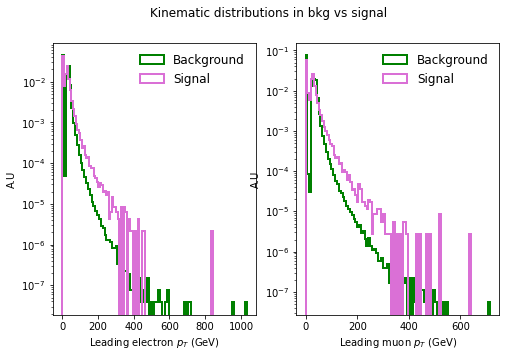

In [5]:
import matplotlib.pyplot as plt

print(" Training (#samples,#features):", X_train.shape)
print(" Testing  (#samples,#features):", signal_test_data.shape)

fig, axs = plt.subplots(1,2,figsize=(8,5))
fig.suptitle('Kinematic distributions in bkg vs signal')

axs[0].hist(X_train[:,3],bins=100,label=r'Background',histtype='step', linewidth=2, facecolor='none', edgecolor='green',fill=True,density=True)
axs[0].hist(signal_test_data[:,3],bins=100,label=r'Signal',histtype='step', linewidth=2, facecolor='none', edgecolor='orchid',fill=True,density=True)
axs[0].semilogy()
axs[0].set(xlabel=u'Leading electron $p_{T}$ (GeV)', ylabel='A.U')
axs[0].legend(loc='best',frameon=False, ncol=1,fontsize='large')

axs[1].hist(X_train[:,15],bins=100,label=r'Background',histtype='step', linewidth=2, facecolor='none', edgecolor='green',fill=True,density=True)
axs[1].hist(signal_test_data[:,15],bins=100,label=r'Signal',histtype='step', linewidth=2, facecolor='none', edgecolor='orchid',fill=True,density=True)
axs[1].set(xlabel=u'Leading muon $p_{T}$ (GeV)', ylabel='A.U')
axs[1].semilogy()
axs[1].legend(loc='best',frameon=False, ncol=1,fontsize='large')
print(signal_test_data[3])

# Defining the autoencoder

Now, let's define an autoencoder to learn to reconstruct the training data after compressing it through a bottleneck, then decompressing it again.

<img src="images/ae.png" alt="The autoencoder" width="800" img align="center"/>

For that, we need a stack of dense layers:

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Activation, Concatenate, Dropout, Layer
from tensorflow.keras.layers import ReLU, LeakyReLU

input_shape = 57
latent_dim = 3
#encoder
inputArray = Input(shape=(input_shape))
x = BatchNormalization()(inputArray)
x = Dense(32, kernel_initializer=tf.keras.initializers.HeUniform())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
x = Dense(16, kernel_initializer=tf.keras.initializers.HeUniform())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
encoder = Dense(latent_dim, kernel_initializer=tf.keras.initializers.HeUniform())(x)

#decoder
x = Dense(16, kernel_initializer=tf.keras.initializers.HeUniform())(encoder)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
x = Dense(32, kernel_initializer=tf.keras.initializers.HeUniform())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
decoder = Dense(input_shape, kernel_initializer=tf.keras.initializers.HeUniform())(x)

#create autoencoder
autoencoder = Model(inputs = inputArray, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 57)]              0         
                                                                 
 batch_normalization (BatchN  (None, 57)               228       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                1856      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528   

2021-12-02 22:15:16.391413: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='mse')

# Let's train!

In [8]:
train = True #If you have a pre-trained model you can set this to false and load the other instead
EPOCHS = 150
BATCH_SIZE = 1024

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

callbacks=[]
callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
callbacks.append(TerminateOnNaN())
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, restore_best_weights=True))

if train:
    history = autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val),
                  callbacks=callbacks)
    # Save the model
    autoencoder.save('baseline_ae.h5')
    autoencoder.save_weights('baseline_ae_weights_only.h5')
    
else:
    autoencoder = tf.keras.models.load_model('baseline_ae.h5')

Epoch 1/150
2500/2500 [==============================] - 10s 4ms/step - loss: 85.7794 - val_loss: 83.9660 - lr: 1.0000e-05
Epoch 2/150
2500/2500 [==============================] - 8s 3ms/step - loss: 82.4358 - val_loss: 80.6434 - lr: 1.0000e-05
Epoch 3/150
2500/2500 [==============================] - 8s 3ms/step - loss: 79.0847 - val_loss: 77.1505 - lr: 1.0000e-05
Epoch 4/150
2500/2500 [==============================] - 8s 3ms/step - loss: 75.9488 - val_loss: 74.2155 - lr: 1.0000e-05
Epoch 5/150
2500/2500 [==============================] - 8s 3ms/step - loss: 73.0475 - val_loss: 71.4187 - lr: 1.0000e-05
Epoch 6/150
2500/2500 [==============================] - 8s 3ms/step - loss: 70.3596 - val_loss: 68.9274 - lr: 1.0000e-05
Epoch 7/150
2500/2500 [==============================] - 8s 3ms/step - loss: 67.8517 - val_loss: 66.3850 - lr: 1.0000e-05
Epoch 8/150
2500/2500 [==============================] - 8s 3ms/step - loss: 65.4429 - val_loss: 64.1293 - lr: 1.0000e-05
Epoch 9/150
2500/2500 [

2500/2500 [==============================] - 9s 3ms/step - loss: 2.6768 - val_loss: 2.1934 - lr: 1.0000e-05
Epoch 69/150
2500/2500 [==============================] - 9s 4ms/step - loss: 2.6749 - val_loss: 2.1733 - lr: 1.0000e-05
Epoch 70/150
2500/2500 [==============================] - 8s 3ms/step - loss: 2.6551 - val_loss: 2.1632 - lr: 1.0000e-05
Epoch 71/150
2500/2500 [==============================] - 9s 3ms/step - loss: 2.6573 - val_loss: 2.1872 - lr: 1.0000e-05
Epoch 72/150
2489/2500 [============================>.] - ETA: 0s - loss: 2.6280
Epoch 00072: ReduceLROnPlateau reducing learning rate to 1e-06.
2500/2500 [==============================] - 8s 3ms/step - loss: 2.6385 - val_loss: 2.1660 - lr: 1.0000e-05
Epoch 73/150
2500/2500 [==============================] - 9s 4ms/step - loss: 2.6420 - val_loss: 2.1648 - lr: 1.0000e-06
Epoch 74/150
2500/2500 [==============================] - 9s 3ms/step - loss: 2.6340 - val_loss: 2.1498 - lr: 1.0000e-06
Epoch 75/150
2500/2500 [==========

# Evaluating the model performance

Remember that the key metric we use for anomaly detection is the mean-squared-error: If the error is high, the data is more likely to be anomalous, and if the error is low, the data is similar to the training data (which in our case is SM events). We therefore first need to run `model.predict()` in order to get the AE reconstructed output, both for our vanilla SM test data, and for our new leptoquark signal!

In [9]:
bkg_prediction = autoencoder.predict(X_test)
signal_prediction = autoencoder.predict(signal_test_data)

We then need to compute the mean-square-error, which will be our final discriminating variable

In [10]:
def mse_loss(true, prediction):
    loss = tf.reduce_mean(tf.math.square(true - prediction),axis=-1)
    return loss

# compute loss value of input data versus AE reconstructed data
mse_sm = mse_loss(X_test, bkg_prediction.astype(np.float32)).numpy()
mse_bsm = mse_loss(signal_test_data,signal_prediction.astype(np.float32)).numpy()

Now, let's look at our discriminant!

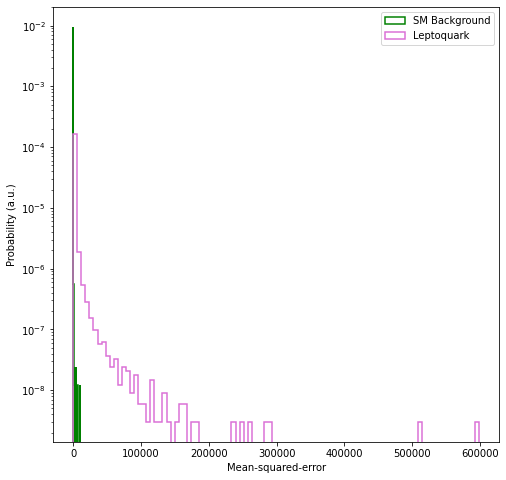

In [11]:
bin_size=100

plt.figure(figsize=(8,8))
plt.hist(mse_sm, bins=bin_size, label="SM Background", density = True, histtype='step', fill=False, edgecolor='green', linewidth=1.5)
plt.hist(mse_bsm, bins=bin_size, label="Leptoquark", density = True, histtype='step', fill=False, edgecolor='orchid', linewidth=1.5)
plt.yscale('log')
plt.xlabel("Mean-squared-error")
plt.ylabel("Probability (a.u.)")
plt.legend(loc='best')
plt.show()

There seems to be some discrimination power if we cut at very high values of the MSE! Let's look at a ROC curve to make it easier to vizualize

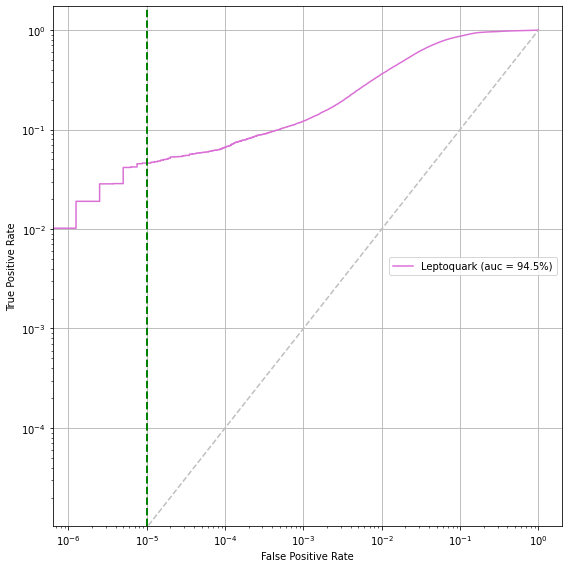

In [12]:
from sklearn.metrics import roc_curve, auc

target_background = np.zeros(mse_sm.shape[0])

plt.figure(figsize=(8,8))
trueVal = np.concatenate((np.ones(mse_bsm.shape[0]), target_background)) # anomaly=1, bkg=0
predVal_loss = np.concatenate((mse_bsm, mse_sm))

fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

auc_loss = auc(fpr_loss, tpr_loss)
    
plt.plot(fpr_loss, tpr_loss, "-", label='Leptoquark (auc = %.1f%%)'%(auc_loss*100.), linewidth=1.5, color = "orchid")
    
plt.semilogx()
plt.semilogy()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc='center right')
plt.grid(True)
plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='green', linestyle='dashed', linewidth=2) # threshold value for measuring anomaly detection efficiency
plt.show()

Pretty good! So at a false positive rate of 10E-5, the signal efficiency is almost three orders of magnitude higher! This can obviously be further improved, but I leave that up to you :)

## Model compression

Now, there is absolutely no way anyone would let you deploy this model on an FPGA in the trigger. It will use far too many resources! Luckily, as we discussed in the lecture, there are some cheap tricks you can perform to compress the model. These are pruning and quantization-aware-training and both are very easily implemented. Let's have a look.

To quantize the model during training, such that the network will get the opportunity to adapt to the narrower bitwidth we use the library [QKeras](https://www.nature.com/articles/s42256-021-00356-5.epdf?sharing_token=A6MQVmmncHNyCtDUXzrqtNRgN0jAjWel9jnR3ZoTv0N3uekY-CrHD1aJ9BTeJNRfQ1EhZ9jJIhgZjfrQxrmxMLMZ4eGzSeru7-ASFE-Xt3NVE6yorlffwUN0muAm1auU2I6-5ug4bOLCRYvA0mp-iT-OdPsrBYeH0IHRYx0t3wc%3D), developed in a joint effort between CERN and Google.

In [26]:
from qkeras import QDense, QActivation

#encoder
inputArray = Input(shape=(input_shape))
x = BatchNormalization()(inputArray)
x = QDense(32, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(10,1,1, alpha=1.0)',
               bias_quantizer='quantized_bits(10,1,1, alpha=1.0)')(x)
x = BatchNormalization()(x)
x = QActivation('quantized_relu(bits=10)')(x)
x = QDense(16, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(10,1,1, alpha=1.0)',
               bias_quantizer='quantized_bits(10,1,1, alpha=1.0)')(x)
x = BatchNormalization()(x)
x = QActivation('quantized_relu(bits=10)')(x)
encoder = QDense(latent_dim, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(10,1,1, alpha=1.0)',
               bias_quantizer='quantized_bits(10,1,1, alpha=1.0)', name='bottleneck')(x)

#decoder
x = QDense(16, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(10,1,1, alpha=1.0)',
               bias_quantizer='quantized_bits(10,1,1, alpha=1.0)')(encoder)
x = BatchNormalization()(x)
x = QActivation('quantized_relu(bits=10)')(x)
x = QDense(32, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(10,1,1, alpha=1.0)',
               bias_quantizer='quantized_bits(10,1,1, alpha=1.0)')(x)
x = BatchNormalization()(x)
x = QActivation('quantized_relu(bits=10)')(x)
decoder = QDense(input_shape, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(10,1,1, alpha=1.0)',
               bias_quantizer='quantized_bits(10,1,1, alpha=1.0)')(x)

#create autoencoder
q_autoencoder = Model(inputs = inputArray, outputs=decoder)
q_autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 57)]              0         
                                                                 
 batch_normalization_15 (Bat  (None, 57)               228       
 chNormalization)                                                
                                                                 
 q_dense_11 (QDense)         (None, 32)                1856      
                                                                 
 batch_normalization_16 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 q_activation_8 (QActivation  (None, 32)               0         
 )                                                               
                                                           

Easy as that! Let's add some pruning on top, 30% sparsity (removing 30% of the weights). Let's make sure to skip our latent dimension!

In [27]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

def pruneFunction(layer):
    pruning_params = {'pruning_schedule': pruning_schedule.PolynomialDecay(initial_sparsity=0.05,final_sparsity=0.30, begin_step=1000, end_step=8000, frequency=100)}
    if isinstance(layer, tf.keras.layers.Dense) and layer.name!='bottleneck':
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)  
    return layer

q_autoencoder.load_weights('baseline_ae_weights_only.h5')
q_autoencoder = tf.keras.models.clone_model( q_autoencoder, clone_function=pruneFunction)


In [28]:
q_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='mse')

train = True
EPOCHS = 150
BATCH_SIZE = 1024

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

callbacks=[]
callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
callbacks.append(TerminateOnNaN())
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, restore_best_weights=True))
callbacks.append(pruning_callbacks.UpdatePruningStep())
if train:
        
    history = q_autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val),
                  callbacks=callbacks)
    # Save the model
    q_autoencoder.save('qkeras_ae.h5')
    
else:
    q_autoencoder = tf.keras.models.load_model('qkeras_ae.h5')
    

Epoch 1/150
2500/2500 [==============================] - 14s 5ms/step - loss: 39.6274 - val_loss: 38.1262 - lr: 1.0000e-05
Epoch 2/150
2500/2500 [==============================] - 11s 4ms/step - loss: 37.6159 - val_loss: 36.3640 - lr: 1.0000e-05
Epoch 3/150
2500/2500 [==============================] - 12s 5ms/step - loss: 36.2074 - val_loss: 35.2100 - lr: 1.0000e-05
Epoch 4/150
2500/2500 [==============================] - 12s 5ms/step - loss: 35.0605 - val_loss: 34.1533 - lr: 1.0000e-05
Epoch 5/150
2500/2500 [==============================] - 12s 5ms/step - loss: 34.0568 - val_loss: 33.2154 - lr: 1.0000e-05
Epoch 6/150
2500/2500 [==============================] - 11s 4ms/step - loss: 33.1293 - val_loss: 32.3156 - lr: 1.0000e-05
Epoch 7/150
2500/2500 [==============================] - 11s 4ms/step - loss: 32.2300 - val_loss: 31.4323 - lr: 1.0000e-05
Epoch 8/150
2500/2500 [==============================] - 12s 5ms/step - loss: 31.3782 - val_loss: 30.6334 - lr: 1.0000e-05
Epoch 9/150
2500

2500/2500 [==============================] - 12s 5ms/step - loss: 18.0464 - val_loss: 17.7515 - lr: 1.0000e-05
Epoch 68/150
2500/2500 [==============================] - 11s 5ms/step - loss: 18.0164 - val_loss: 17.7180 - lr: 1.0000e-05
Epoch 69/150
2500/2500 [==============================] - 12s 5ms/step - loss: 17.9881 - val_loss: 17.6898 - lr: 1.0000e-05
Epoch 70/150
2500/2500 [==============================] - 12s 5ms/step - loss: 17.9622 - val_loss: 17.6665 - lr: 1.0000e-05
Epoch 71/150
2500/2500 [==============================] - 13s 5ms/step - loss: 17.9395 - val_loss: 17.6443 - lr: 1.0000e-05
Epoch 72/150
2500/2500 [==============================] - 12s 5ms/step - loss: 17.9171 - val_loss: 17.6220 - lr: 1.0000e-05
Epoch 73/150
2500/2500 [==============================] - 11s 5ms/step - loss: 17.8932 - val_loss: 17.6004 - lr: 1.0000e-05
Epoch 74/150
2500/2500 [==============================] - 12s 5ms/step - loss: 17.8696 - val_loss: 17.5767 - lr: 1.0000e-05
Epoch 75/150
2500/250

Epoch 133/150
2500/2500 [==============================] - 13s 5ms/step - loss: 17.0381 - val_loss: 16.7494 - lr: 1.0000e-05
Epoch 134/150
2500/2500 [==============================] - 12s 5ms/step - loss: 17.0300 - val_loss: 16.7427 - lr: 1.0000e-05
Epoch 135/150
2500/2500 [==============================] - 12s 5ms/step - loss: 17.0215 - val_loss: 16.7359 - lr: 1.0000e-05
Epoch 136/150
2500/2500 [==============================] - 12s 5ms/step - loss: 17.0136 - val_loss: 16.7246 - lr: 1.0000e-05
Epoch 137/150
2500/2500 [==============================] - 11s 5ms/step - loss: 17.0043 - val_loss: 16.7163 - lr: 1.0000e-05
Epoch 138/150
2500/2500 [==============================] - 11s 5ms/step - loss: 16.9962 - val_loss: 16.7088 - lr: 1.0000e-05
Epoch 139/150
2500/2500 [==============================] - 12s 5ms/step - loss: 16.9906 - val_loss: 16.7041 - lr: 1.0000e-05
Epoch 140/150
2500/2500 [==============================] - 11s 5ms/step - loss: 16.9865 - val_loss: 16.6989 - lr: 1.0000e-05


Let's compare the performance to the floating point precision, unpruned model:

In [29]:
bkg_prediction = q_autoencoder.predict(X_test)
signal_prediction = q_autoencoder.predict(signal_test_data)

# compute loss value of input data versus AE reconstructed data
q_mse_sm = mse_loss(X_test, bkg_prediction.astype(np.float32)).numpy()
q_mse_bsm = mse_loss(signal_test_data,signal_prediction.astype(np.float32)).numpy()

target_background = np.zeros(q_mse_sm.shape[0])

plt.figure(figsize=(8,8))
trueVal = np.concatenate((np.ones(q_mse_bsm.shape[0]), target_background)) # anomaly=1, bkg=0
predVal_loss = np.concatenate((q_mse_bsm, q_mse_sm))

q_fpr_loss, q_tpr_loss, q_threshold_loss = roc_curve(trueVal, predVal_loss)

q_auc_loss = auc(q_fpr_loss, q_tpr_loss)

<Figure size 576x576 with 0 Axes>

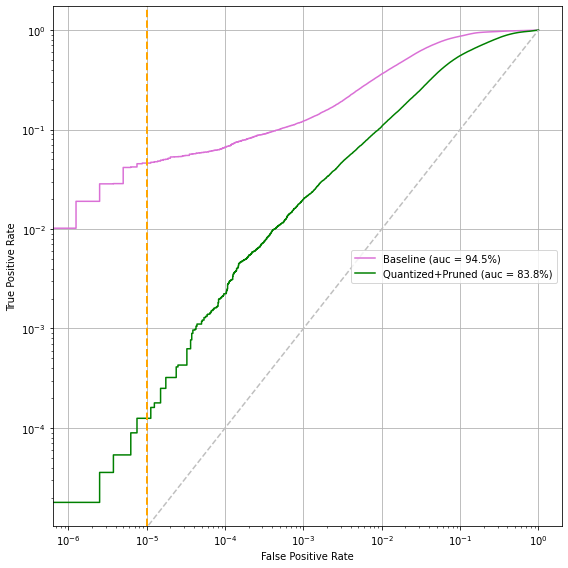

In [30]:
plt.figure(figsize=(8,8))
    
plt.plot(fpr_loss, tpr_loss, "-", label='Baseline (auc = %.1f%%)'%(auc_loss*100.), linewidth=1.5, color = "orchid")
plt.plot(q_fpr_loss, q_tpr_loss, "-", label='Quantized+Pruned (auc = %.1f%%)'%(q_auc_loss*100.), linewidth=1.5, color = "green")

plt.semilogx()
plt.semilogy()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc='center right')
plt.grid(True)
plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='orange', linestyle='dashed', linewidth=2) # threshold value for measuring anomaly detection efficiency
plt.show()

OUCH! We really took a hit. Well, whatever. Let's tune that another time and now try deploying these models!!